# Phát hiện gian lận thẻ tín dụng sử dụng Deep Autoencoders

## Tổng quan dự án
Dự án này triển khai hệ thống phát hiện bất thường cho gian lận thẻ tín dụng sử dụng Deep Autoencoder.
Nguyên lý cốt lõi là huấn luyện mô hình **chỉ trên các giao dịch bình thường**. Autoencoder học cách nén và tái tạo các mẫu dữ liệu bình thường. Khi một giao dịch gian lận (bất thường) được đưa vào mô hình, lỗi tái tạo sẽ cao hơn đáng kể vì mô hình chưa học mẫu đó.

## Các bước thực hiện:
1.  **EDA**: Trực quan hóa sự mất cân bằng lớp.
2.  **Tiền xử lý**: Chuẩn hóa dữ liệu và chia thành tập Train/Test.
3.  **Mô hình**: Xây dựng mạng Dense Autoencoder.
4.  **Huấn luyện**: Chỉ huấn luyện trên dữ liệu Bình thường.
5.  **Đánh giá**: Tính toán Lỗi tái tạo và thiết lập Ngưỡng.

## 1. Import thư viện

In [1]:
# Nhập các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, precision_score, recall_score, f1_score

# Thiết lập random seed để đảm bảo tính tái lập
np.random.seed(42)
torch.manual_seed(42)

try:
    df = pd.read_csv('CreditCard/creditcard.csv')
except FileNotFoundError:
    print("Không tìm thấy tệp. Vui lòng kiểm tra đường dẫn.")

# Hiển thị vài dòng đầu tiên
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. Trực quan hóa sự mất cân bằng lớp
Bộ dữ liệu bị mất cân bằng cao, điều này là điển hình cho việc phát hiện gian lận. Hầu hết các giao dịch là bình thường (Lớp 0), và chỉ một phần nhỏ là gian lận (Lớp 1).

Class
0    284315
1       492
Name: count, dtype: int64


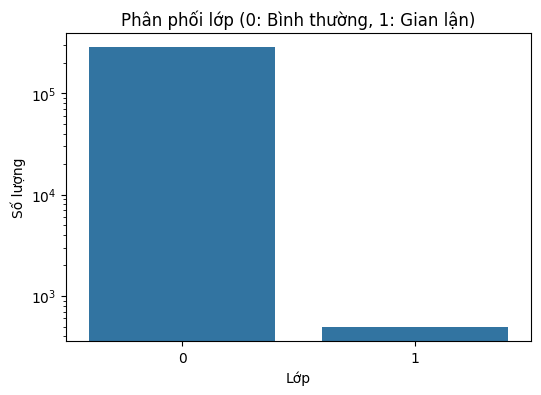

Tỷ lệ gian lận: 0.1727%


In [2]:
# Kiểm tra phân phối của cột Class
class_counts = df['Class'].value_counts()
print(class_counts)

# Trực quan hóa sự mất cân bằng
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Phân phối lớp (0: Bình thường, 1: Gian lận)')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.yscale('log') # Sử dụng thang đo log để nhìn rõ hơn thanh gian lận
plt.show()

# Tính phần trăm gian lận
fraud_percentage = (df[df['Class'] == 1].shape[0] / df.shape[0]) * 100
print(f"Tỷ lệ gian lận: {fraud_percentage:.4f}%")

## 3. Tiền xử lý dữ liệu
- Chuẩn hóa các cột 'Time' và 'Amount'. Các đặc trưng khác (V1-V28) đã là kết quả của biến đổi PCA và đã được chuẩn hóa.
- Loại bỏ cột 'Time' vì nó có thể không hữu ích lắm cho phương pháp phát hiện bất thường cụ thể này nếu không có thêm kỹ thuật đặc trưng, và chuẩn hóa cột 'Amount'.

In [3]:
# Loại bỏ cột Time
data = df.drop(['Time'], axis=1)

# Tách cột Class ra trước khi chuẩn hóa
X = data.drop(['Class'], axis=1)
y = data['Class']

# Chuẩn hóa TOÀN BỘ các đặc trưng (V1-V28 và Amount)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tạo lại DataFrame
data = pd.DataFrame(X_scaled, columns=X.columns)
data['Class'] = y.values

print("Kích thước dữ liệu sau khi tiền xử lý:", data.shape)
print("Đã chuẩn hóa tất cả các đặc trưng (V1-V28 + Amount).")
data.head()

Kích thước dữ liệu sau khi tiền xử lý: (284807, 30)
Đã chuẩn hóa tất cả các đặc trưng (V1-V28 + Amount).


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0


## 4. Chia dữ liệu: Chỉ huấn luyện trên các giao dịch Bình thường
**Bước quan trọng**: Chúng ta huấn luyện Autoencoder CHỈ trên các giao dịch bình thường.
1. Chia dữ liệu thành Bình thường và Gian lận.
2. Chia dữ liệu Bình thường thành Train và Test.
3. Tập Test sẽ chứa hỗn hợp của Bình thường (từ việc chia tách) và TẤT CẢ các giao dịch Gian lận.
   *Thực tế, để đánh giá sạch, chúng ta thường giữ lại một số dữ liệu Bình thường để kiểm tra và trộn nó với dữ liệu Gian lận.*
   
   Chiến lược:
   - `X_train`: 80% các giao dịch Bình thường.
   - `X_test`: 20% các giao dịch Bình thường + Tất cả các giao dịch Gian lận.
   
   Bằng cách này, `X_train` là dữ liệu bình thường thuần túy để Autoencoder học "sự bình thường". `X_test` đại diện cho kịch bản thực tế với các bất thường.

In [4]:
# Tách các giao dịch Bình thường và Gian lận
normal_data = data[data['Class'] == 0]
fraud_data = data[data['Class'] == 1]

print(f"Giao dịch bình thường: {normal_data.shape[0]}")
print(f"Giao dịch gian lận: {fraud_data.shape[0]}")

# Loại bỏ cột Class vì chúng ta không cần nhãn để huấn luyện Autoencoder (Không giám sát)

# Chia dữ liệu Bình thường thành Train và Test (80/20)
X_train_normal, X_test_normal = train_test_split(normal_data, test_size=0.2, random_state=42)

# Loại bỏ cột 'Class' khỏi dữ liệu huấn luyện
X_train = X_train_normal.drop(['Class'], axis=1)

# Tạo tập Test: Kết hợp dữ liệu Bình thường còn lại với TẤT CẢ dữ liệu Gian lận
X_test_all = pd.concat([X_test_normal, fraud_data])

# Tách đặc trưng và nhãn cho tập kiểm tra
y_test = X_test_all['Class']
X_test = X_test_all.drop(['Class'], axis=1)

print(f"Kích thước tập huấn luyện (Chỉ bình thường): {X_train.shape}")
print(f"Kích thước tập kiểm tra (Hỗn hợp): {X_test.shape}")
print(f"Phân phối lớp tập kiểm tra:\n{y_test.value_counts()}")

Giao dịch bình thường: 284315
Giao dịch gian lận: 492
Kích thước tập huấn luyện (Chỉ bình thường): (227452, 29)
Kích thước tập kiểm tra (Hỗn hợp): (57355, 29)
Phân phối lớp tập kiểm tra:
Class
0    56863
1      492
Name: count, dtype: int64


In [5]:
# # Xử lý ngoại lai (Outlier) trong tập huấn luyện bằng Isolation Forest

# from sklearn.ensemble import IsolationForest

# print(f"Kích thước X_train trước khi lọc: {X_train.shape}")

# # Khởi tạo Isolation Forest
# iso_forest = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)

# # Fit và dự đoán trên X_train
# preds = iso_forest.fit_predict(X_train)

# # Chỉ giữ lại các mẫu là Inlier (preds == 1)
# X_train_clean = X_train[preds == 1]
# n_outliers = np.sum(preds == -1)

# print(f"Số lượng mẫu ngoại lai bị loại bỏ: {n_outliers}")
# print(f"Kích thước X_train sau khi lọc: {X_train_clean.shape}")

# # Cập nhật lại X_train để huấn luyện Autoencoder
# X_train = X_train_clean

## 5. Xây dựng kiến trúc mô hình Autoencoder
- **Lớp đầu vào**: Số lượng đặc trưng (29).
- **Encoder**: Nén đầu vào xuống chiều thấp hơn.
- **Decoder**: Tái tạo đầu vào từ chiều thấp hơn.
- **Lớp đầu ra**: Cùng chiều với đầu vào.
- **Hàm kích hoạt**: ReLU cho các lớp ẩn. Lớp đầu ra sẽ không sử dụng hàm kích hoạt (tương đương Linear) vì dữ liệu đã được chuẩn hóa bằng StandardScaler (có thể nhận giá trị âm và dương bất kỳ).

In [6]:
input_dim = X_train.shape[1]

# Định nghĩa mô hình Autoencoder bằng PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.Tanh(),
            nn.Linear(24, 16),
            nn.Tanh(),
            nn.Linear(16, 10),
            nn.Tanh()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.Tanh(),
            nn.Linear(16, 24),
            nn.Tanh(),
            nn.Linear(24, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder(input_dim)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=24, bias=True)
    (1): Tanh()
    (2): Linear(in_features=24, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=10, bias=True)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=24, bias=True)
    (3): Tanh()
    (4): Linear(in_features=24, out_features=29, bias=True)
  )
)


## 6. Huấn luyện Autoencoder

Đang huấn luyện trên thiết bị: cuda


Epoch 1/50, Average Loss: 0.644470


Epoch 2/50, Average Loss: 0.491497


Epoch 3/50, Average Loss: 0.430594


Epoch 4/50, Average Loss: 0.392265


Epoch 5/50, Average Loss: 0.372149


Epoch 6/50, Average Loss: 0.358437


Epoch 7/50, Average Loss: 0.346477


Epoch 8/50, Average Loss: 0.334759


Epoch 9/50, Average Loss: 0.324721


Epoch 10/50, Average Loss: 0.317327


Epoch 11/50, Average Loss: 0.310336


Epoch 12/50, Average Loss: 0.304654


Epoch 13/50, Average Loss: 0.300351


Epoch 14/50, Average Loss: 0.296659


Epoch 15/50, Average Loss: 0.291983


Epoch 16/50, Average Loss: 0.287833


Epoch 17/50, Average Loss: 0.283780


Epoch 18/50, Average Loss: 0.280425


Epoch 19/50, Average Loss: 0.277245


Epoch 20/50, Average Loss: 0.274512


Epoch 21/50, Average Loss: 0.271578


Epoch 22/50, Average Loss: 0.267804


Epoch 23/50, Average Loss: 0.262668


Epoch 24/50, Average Loss: 0.257158


Epoch 25/50, Average Loss: 0.252752


Epoch 26/50, Average Loss: 0.247866


Epoch 27/50, Average Loss: 0.244358


Epoch 28/50, Average Loss: 0.241366


Epoch 29/50, Average Loss: 0.239024


Epoch 30/50, Average Loss: 0.236479


Epoch 31/50, Average Loss: 0.234778


Epoch 32/50, Average Loss: 0.233105


Epoch 33/50, Average Loss: 0.231035


Epoch 34/50, Average Loss: 0.230196


Epoch 35/50, Average Loss: 0.229547


Epoch 36/50, Average Loss: 0.227976


Epoch 37/50, Average Loss: 0.226658


Epoch 38/50, Average Loss: 0.225629


Epoch 39/50, Average Loss: 0.224769


Epoch 40/50, Average Loss: 0.223826


Epoch 41/50, Average Loss: 0.222866


Epoch 42/50, Average Loss: 0.221370


Epoch 43/50, Average Loss: 0.221255


Epoch 44/50, Average Loss: 0.219265


Epoch 45/50, Average Loss: 0.218273


Epoch 46/50, Average Loss: 0.217337


Epoch 47/50, Average Loss: 0.216179


Epoch 48/50, Average Loss: 0.215236


Epoch 49/50, Average Loss: 0.214719


Epoch 50/50, Average Loss: 0.213500
Đã tải lại mô hình tốt nhất với Loss: 0.213500


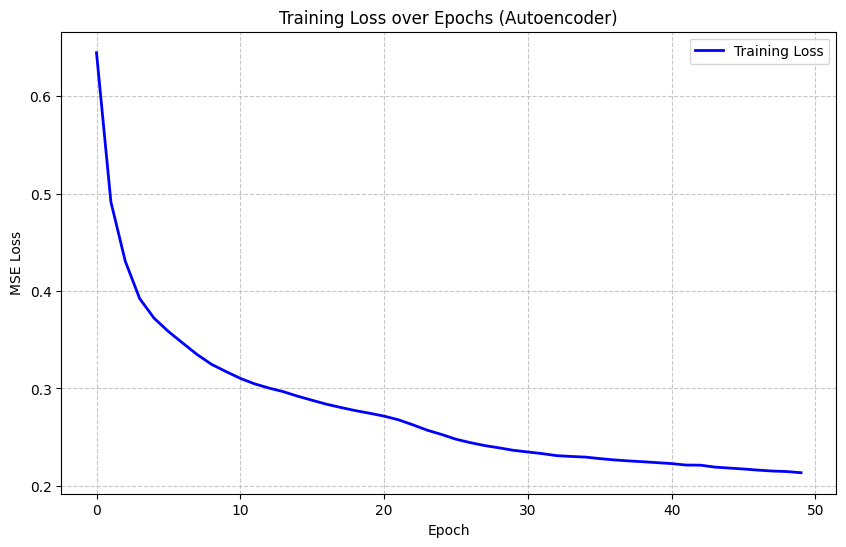

In [7]:
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Đang huấn luyện trên thiết bị: {device}")

# Chuyển đổi dữ liệu sang PyTorch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Khởi tạo Model
model = Autoencoder(input_dim=X_train.shape[1]).to(device)

# Định nghĩa hàm mất mát và bộ tối ưu
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Huấn luyện mô hình
num_epochs = 50
train_losses = []
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Sử dụng tqdm
    with tqdm(train_loader, unit="batch", leave=False) as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
        
        for inputs, targets in tepoch:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            # Hiển thị loss của batch hiện tại
            tepoch.set_postfix(batch_loss=loss.item())
    
    # Tính loss trung bình của epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss:.6f}")
    
    # Lưu lại trọng số tốt nhất (Model Checkpoint)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

# Tải lại trọng số tốt nhất sau khi huấn luyện xong
model.load_state_dict(best_model_wts)
print(f"Đã tải lại mô hình tốt nhất với Loss: {best_loss:.6f}")

# Vẽ biểu đồ loss huấn luyện
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='b', linewidth=2)
plt.title('Training Loss over Epochs (Autoencoder)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## 7. Tính toán Lỗi tái tạo trên tập Test
- Tính toán MSE giữa `X_test` gốc và `X_test_pred` được tái tạo.
- MSE này là "Lỗi tái tạo" hoặc "Điểm bất thường".

In [8]:
# Chuyển đổi tập test sang Tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

# Lấy kết quả tái tạo
model.eval()
with torch.no_grad():
    X_test_pred_tensor = model(X_test_tensor)
    # Chuyển kết quả về CPU trước khi chuyển sang numpy
    X_test_pred = X_test_pred_tensor.cpu().numpy()

# Tính MSE cho mỗi giao dịch
mse = np.mean(np.power(X_test.values - X_test_pred, 2), axis=1)

# Tạo DataFrame để phân tích kết quả
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.head(10)

,reconstruction_error,true_class
138028,0.084650,0
63099,0.022844,0
73411,0.111986,0
164247,0.046674,0
148999,0.170328,0
38488,0.034000,0
153861,0.361972,0
20458,0.019107,0
158719,0.126619,0
10980,0.052866,0


## 8. Trực quan hóa phân phối Lỗi tái tạo (Bình thường vs. Gian lận)
- Mong đợi: Các giao dịch Bình thường có lỗi tái tạo thấp và các giao dịch Gian lận có lỗi tái tạo cao.

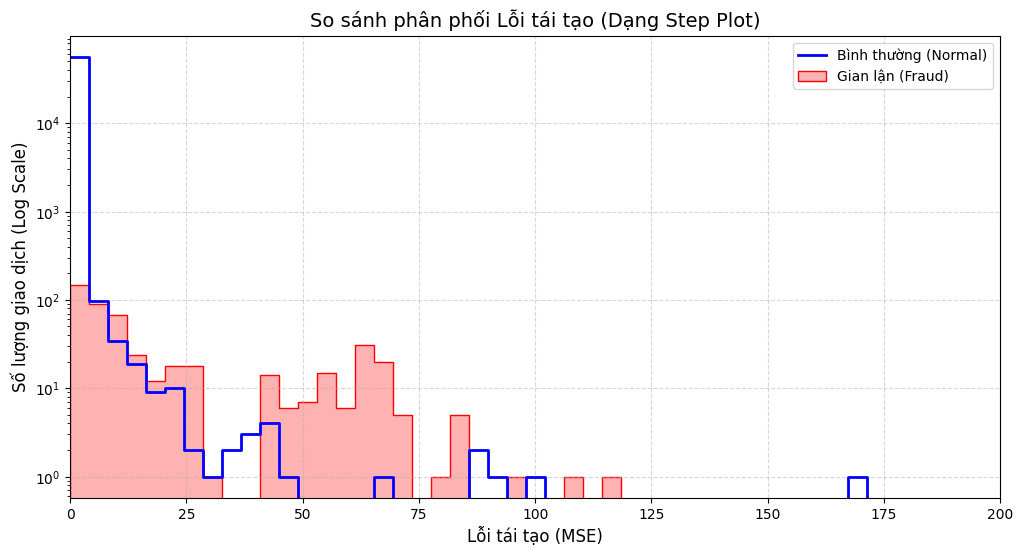

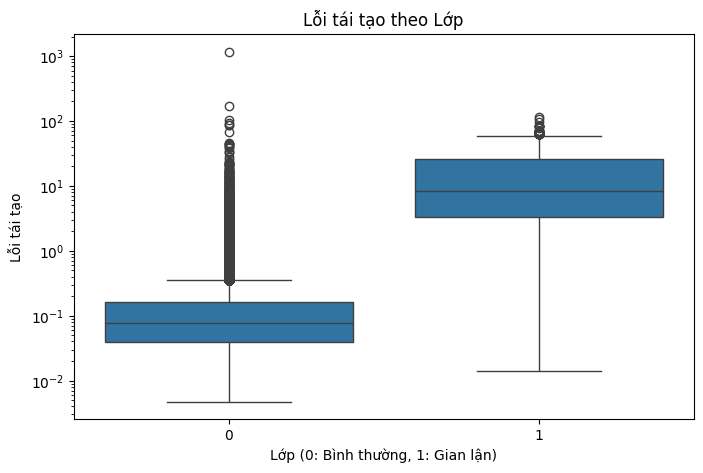

In [9]:
plt.figure(figsize=(12, 6))

# Define lại bin cho mượt
bins_list = np.linspace(0, 200, 50)

# Vẽ Histogram
sns.histplot(error_df[error_df['true_class'] == 0]['reconstruction_error'],
             bins=bins_list,
             color='blue', label='Bình thường (Normal)',
             element="step", fill=False,
             stat="count", linewidth=2)

sns.histplot(error_df[error_df['true_class'] == 1]['reconstruction_error'],
             bins=bins_list,
             color='red', label='Gian lận (Fraud)',
             element="step", fill=True, alpha=0.3,
             stat="count")

plt.xlim(0, 200)
plt.yscale('log')

plt.title('So sánh phân phối Lỗi tái tạo (Dạng Step Plot)', fontsize=14)
plt.xlabel('Lỗi tái tạo (MSE)', fontsize=12)
plt.ylabel('Số lượng giao dịch (Log Scale)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

# Biểu đồ hộp để xem sự phân tách rõ hơn
plt.figure(figsize=(8, 5))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df)
plt.title('Lỗi tái tạo theo Lớp')
plt.xlabel('Lớp (0: Bình thường, 1: Gian lận)')
plt.ylabel('Lỗi tái tạo')
plt.yscale('log')
plt.show()

## 9. Xác định Ngưỡng để phát hiện gian lận
Chúng ta cần chọn một ngưỡng. Nếu Lỗi > Ngưỡng, chúng ta dự đoán là Gian lận.
Các phương pháp phổ biến:
1.  **Phân vị**: ví dụ, phân vị thứ 99 của lỗi Bình thường.
2.  **Đường cong Precision-Recall**: Tìm ngưỡng mang lại sự cân bằng tốt nhất.

Hãy xem đường cong Precision-Recall.

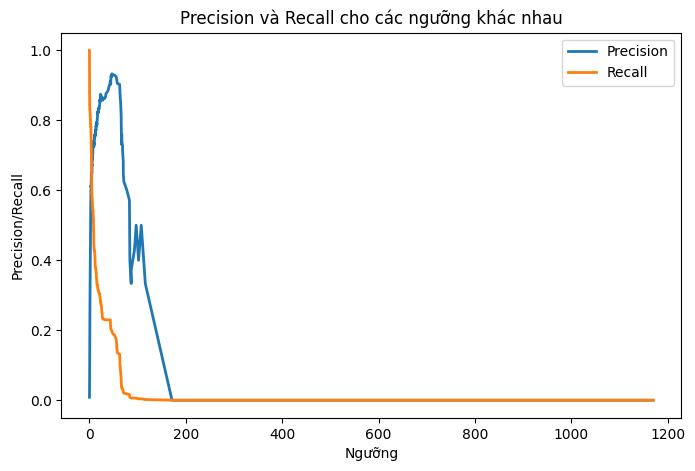

Ngưỡng tốt nhất (Max F1 Score): 3.2461545255309434
Max F1 Score: 0.6781504986400725
Số lượng giao dịch dự đoán là gian lận với ngưỡng này: 609


In [ ]:
precision, recall, thresholds = precision_recall_curve(error_df['true_class'], error_df['reconstruction_error'])

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], label="Recall", linewidth=2)
plt.title('Precision và Recall cho các ngưỡng khác nhau')
plt.xlabel('Ngưỡng')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# Tính F1 Score cho từng ngưỡng
numerator = 2 * precision[:-1] * recall[:-1]
denominator = precision[:-1] + recall[:-1]

# Xử lý trường hợp chia cho 0
f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)

# Tìm ngưỡng tối ưu F1
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print("Ngưỡng tốt nhất (Max F1 Score):", best_threshold)
print("Max F1 Score:", f1_scores[best_threshold_idx])

# Kiểm tra xem ngưỡng này có dự đoán ra ca gian lận nào không
num_predicted_fraud = np.sum(error_df['reconstruction_error'] > best_threshold)
print(f"Số lượng giao dịch dự đoán là gian lận với ngưỡng này: {num_predicted_fraud}")

# Nếu không bắt được ca nào (hoặc quá ít), có thể fallback về phương pháp thống kê
if num_predicted_fraud == 0:
    print("Cảnh báo: Ngưỡng F1 không bắt được giao dịch gian lận nào. Chuyển sang phương pháp Mean + 2*Std.")
    threshold_fixed = np.mean(mse[y_test==0]) + 2 * np.std(mse[y_test==0])
    best_threshold = threshold_fixed
    print("Ngưỡng mới:", best_threshold)

## 10. Các chỉ số đánh giá: Precision, Recall, và Ma trận nhầm lẫn
Sử dụng "Ngưỡng tốt nhất" tìm được ở trên, hãy đánh giá hiệu suất cuối cùng.

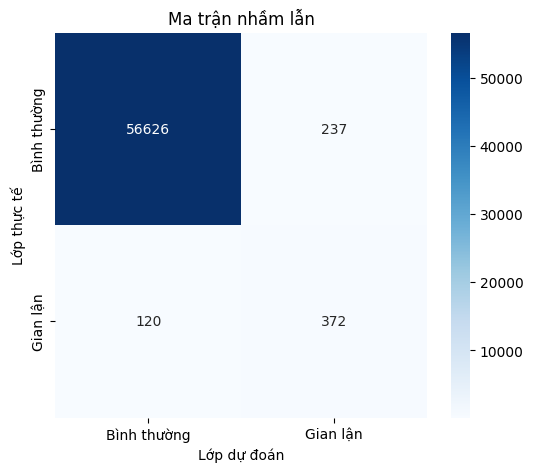

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.61      0.76      0.68       492

    accuracy                           0.99     57355
   macro avg       0.80      0.88      0.84     57355
weighted avg       0.99      0.99      0.99     57355

Precision: 0.6108
Recall: 0.7561
F1 Score: 0.6757


In [11]:
# Phân loại dựa trên ngưỡng
y_pred = [1 if e > best_threshold else 0 for e in error_df['reconstruction_error'].values]

# Ma trận nhầm lẫn
conf_matrix = confusion_matrix(error_df['true_class'], y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Bình thường', 'Gian lận'], yticklabels=['Bình thường', 'Gian lận'])
plt.title('Ma trận nhầm lẫn')
plt.ylabel('Lớp thực tế')
plt.xlabel('Lớp dự đoán')
plt.show()

# Báo cáo phân loại
print("Báo cáo phân loại:")
# Sử dụng zero_division=0 để tránh cảnh báo nếu không dự đoán được lớp nào
print(classification_report(error_df['true_class'], y_pred, zero_division=0))

print(f"Precision: {precision_score(error_df['true_class'], y_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(error_df['true_class'], y_pred, zero_division=0):.4f}")
print(f"F1 Score: {f1_score(error_df['true_class'], y_pred, zero_division=0):.4f}")